In [2]:
# Libreria para cargar nuestro drive
from google.colab import drive
# Cargamos nuestro drive en nuestro notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Librerías de apoyo

In [3]:
# Librerias de apoyo

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from numpy import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

DataFrame de nuestros datos

In [4]:
# Revisamos el directorio de datos

!ls -lth "/content/drive/My Drive/Colab Notebooks/SDC_13/datos"

total 1.3M
drwx------ 2 root root 4.0K Jan 11 23:35 IMG
-rw------- 1 root root 1.3M Jan 11 21:36 driving_log.csv


In [5]:
# Definimos una variable con la dirección del directorio de datos y uno con el nombre de las columnas para el dataframe que estaremos utilizando
datadir = "/content/drive/My Drive/Colab Notebooks/SDC_13/datos"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

In [6]:
# Definimos nuestro DataFrame

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_335.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_335.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_335.jpg,0.0,0.0,0,0.000078
1,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_449.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_449.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_449.jpg,0.0,0.0,0,0.000079
2,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_584.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_584.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_584.jpg,0.0,0.0,0,0.000080
3,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_687.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_687.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_687.jpg,0.0,0.0,0,0.000078
4,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/center_2021_01_11_15_26_24_788.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/left_2021_01_11_15_26_24_788.jpg,/Users/desneruda/Documents/school/CAV/SDC_13/IMG/right_2021_01_11_15_26_24_788.jpg,0.0,0.0,0,0.000083


In [7]:
# Eliminamos toda la parte de la dirección local de las imagenes
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_01_11_15_26_24_335.jpg,left_2021_01_11_15_26_24_335.jpg,right_2021_01_11_15_26_24_335.jpg,0.0,0.0,0,0.000078
1,center_2021_01_11_15_26_24_449.jpg,left_2021_01_11_15_26_24_449.jpg,right_2021_01_11_15_26_24_449.jpg,0.0,0.0,0,0.000079
2,center_2021_01_11_15_26_24_584.jpg,left_2021_01_11_15_26_24_584.jpg,right_2021_01_11_15_26_24_584.jpg,0.0,0.0,0,0.000080
3,center_2021_01_11_15_26_24_687.jpg,left_2021_01_11_15_26_24_687.jpg,right_2021_01_11_15_26_24_687.jpg,0.0,0.0,0,0.000078
4,center_2021_01_11_15_26_24_788.jpg,left_2021_01_11_15_26_24_788.jpg,right_2021_01_11_15_26_24_788.jpg,0.0,0.0,0,0.000083


Exploración y selección de los datos

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee5d9eae10>,
      dtype=object)

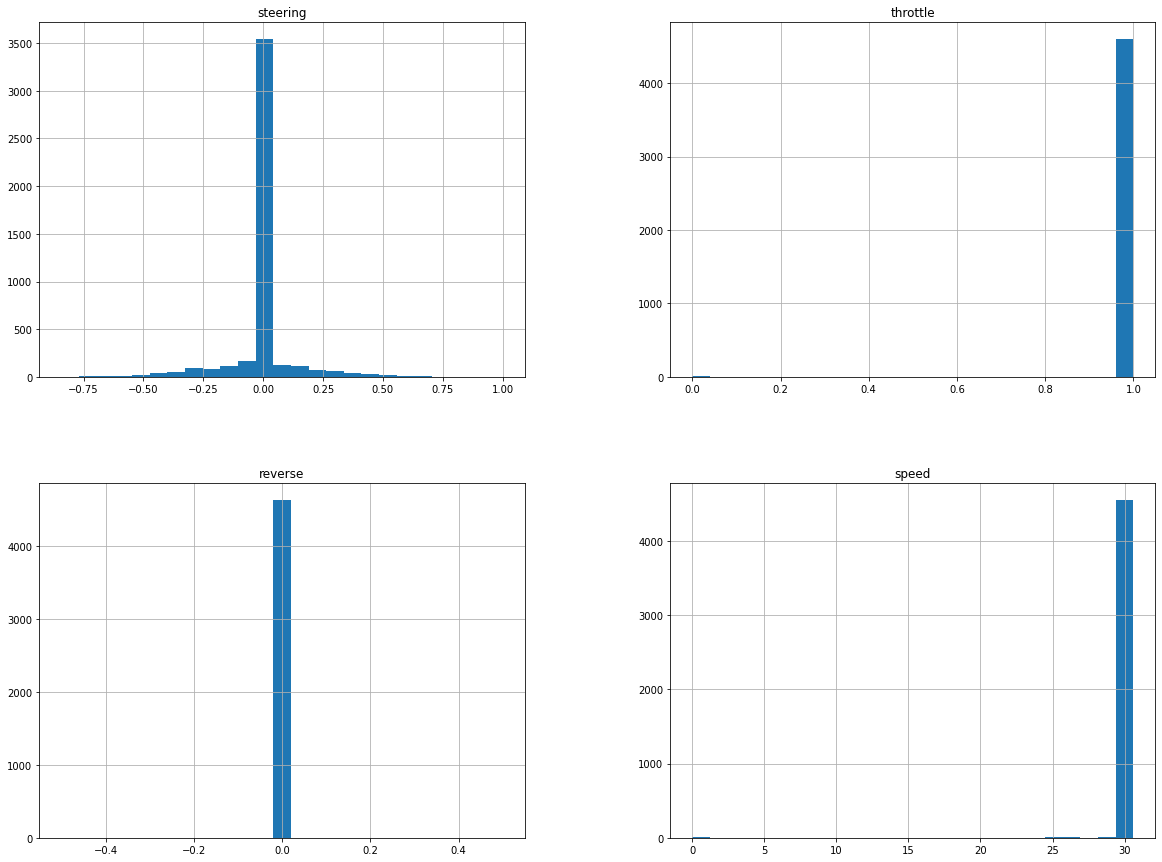

In [8]:
# Exploración de los datos numéricos
data.hist(bins=25, figsize=(20,15))

Remover el exceso de datos con ángulo cero

In [9]:
#Analizamos los datos de steering a través de su histograma

num_bins = 25
hist, bin_edges = np.histogram(data['steering'], num_bins)
center = (bin_edges [:-1]+ bin_edges [1:]) * 0.5

In [10]:
print(center)

[-0.80540823 -0.7317181  -0.65802797 -0.58433784 -0.51064771 -0.43695757
 -0.36326744 -0.28957731 -0.21588718 -0.14219705 -0.06850691  0.00518322
  0.07887335  0.15256348  0.22625361  0.29994375  0.37363388  0.44732401
  0.52101414  0.59470427  0.66839441  0.74208454  0.81577467  0.8894648
  0.96315493]


In [11]:
print(hist)

[   3    5    5    9   23   41   56   90   81  116  169 3539  123  113
   70   60   45   32   15   13    6    3    3    2    4]


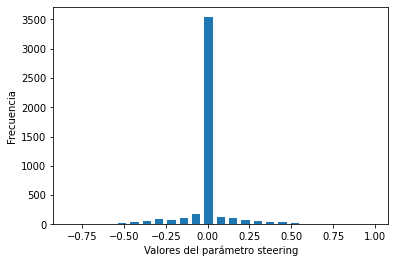

In [12]:
#Graficamos cada valor con su frecuencia
plt.bar(center, hist, width=0.05)
plt.xlabel("Valores del parámetro steering")
plt.ylabel("Frecuencia")
plt.show()

In [13]:
data['steering'][0:9]

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5   -0.123402
6   -0.255300
7    0.000000
8    0.000000
Name: steering, dtype: float64

In [14]:
#Aquí se define el numero máximo de eventos y se eliminan aleatoriamente los restantes
maxFrec = 1500
remove_indexList = []
for i in range(len(data['steering'])):
  if data['steering'][i] == 0.0:
    remove_indexList.append(i)

remove_indexList = shuffle(remove_indexList)
remove_indexList = remove_indexList[maxFrec:]
print('Imágenes eliminadas:', len(remove_indexList))
data.drop(data.index[remove_indexList], inplace=True)
print('Imágenes restantes:', len(data))

Imágenes eliminadas: 1978
Imágenes restantes: 2648


In [15]:
data['steering'][0:10]

0     0.000000
3     0.000000
5    -0.123402
6    -0.255300
8     0.000000
9    -0.166296
10   -0.502236
11   -0.104430
12   -0.071517
13   -0.094245
Name: steering, dtype: float64

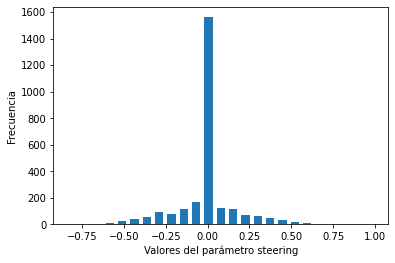

In [16]:
#Graficamos cada valor con su frecuencia

hist, bin_edges = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.xlabel("Valores del parámetro steering")
plt.ylabel("Frecuencia")
plt.show()

Preparación de muestra de datos

In [17]:
#Mostramos el dataFrame que se tiene hasta ahora

data.head(10)

,center,left,right,steering,throttle,reverse,speed
0,center_2021_01_11_15_26_24_335.jpg,left_2021_01_11_15_26_24_335.jpg,right_2021_01_11_15_26_24_335.jpg,0.000000,0.000000,0,0.000078
3,center_2021_01_11_15_26_24_687.jpg,left_2021_01_11_15_26_24_687.jpg,right_2021_01_11_15_26_24_687.jpg,0.000000,0.000000,0,0.000078
5,center_2021_01_11_15_26_24_899.jpg,left_2021_01_11_15_26_24_899.jpg,right_2021_01_11_15_26_24_899.jpg,-0.123402,0.123402,0,0.080300
6,center_2021_01_11_15_26_25_007.jpg,left_2021_01_11_15_26_25_007.jpg,right_2021_01_11_15_26_25_007.jpg,-0.255300,0.440370,0,0.428106
8,center_2021_01_11_15_26_25_240.jpg,left_2021_01_11_15_26_25_240.jpg,right_2021_01_11_15_26_25_240.jpg,0.000000,1.000000,0,2.723454
9,center_2021_01_11_15_26_25_345.jpg,left_2021_01_11_15_26_25_345.jpg,right_2021_01_11_15_26_25_345.jpg,-0.166296,1.000000,0,3.897490
10,center_2021_01_11_15_26_25_449.jpg,left_2021_01_11_15_26_25_449.jpg,right_2021_01_11_15_26_25_449.jpg,-0.502236,1.000000,0,5.022418
11,center_2021_01_11_15_26_25_582.jpg,left_2021_01_11_15_26_25_582.jpg,right_2021_01_11_15_26_25_582.jpg,-0.104430,1.000000,0,6.639550
12,center_2021_01_11_15_26_25_687.jpg,left_2021_01_11_15_26_25_687.jpg,right_2021_01_11_15_26_25_687.jpg,-0.071517,1.000000,0,7.774163
13,center_2021_01_11_15_26_25_797.jpg,left_2021_01_11_15_26_25_797.jpg,right_2021_01_11_15_26_25_797.jpg,-0.094245,1.000000,0,9.108408


In [18]:
print(data.iloc[0])

center      center_2021_01_11_15_26_24_335.jpg
left          left_2021_01_11_15_26_24_335.jpg
right        right_2021_01_11_15_26_24_335.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                              7.79245e-05
Name: 0, dtype: object


In [19]:
# Función que permite tomar únicamente las imágenes del centro y el valor del parámetro steering
def loadData(path, dataframe):
  imagesPath = []
  steering = []
  for i in range(len(dataframe)):
    indexed_data = dataframe.iloc[i]
    name_file=path+"/IMG/"+indexed_data[0]
    imagesPath.append(name_file)
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

In [20]:
image_paths, steerings = loadData(datadir,data)

Separación de muestras de entrenamiento y de test

In [21]:
# La función train_test_split nos permite separar un porcentaje de los datos en entrenamiento y test.
# En este caso usaremos un 20% de test y el resto para entrenamiento (80%)
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
print('Muestras de entrenamiento : ', len(X_train))
print('Muestras de test: ', len(X_test))

Muestras de entrenamiento :  2118
Muestras de test:  530


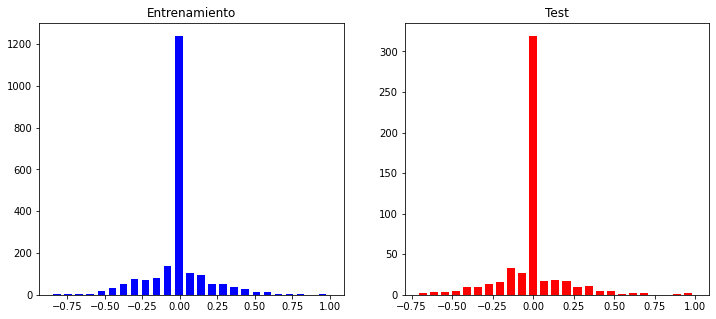

In [22]:
#Graficamos el valor de steerings para ambas muestras

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_train, bins=num_bins, width=0.05, color='blue')
plt.title("Entrenamiento")
plt.subplot(1,2,2)
plt.hist(y_test, bins=num_bins, width=0.05, color='red')
plt.title("Test")
plt.show()

In [23]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

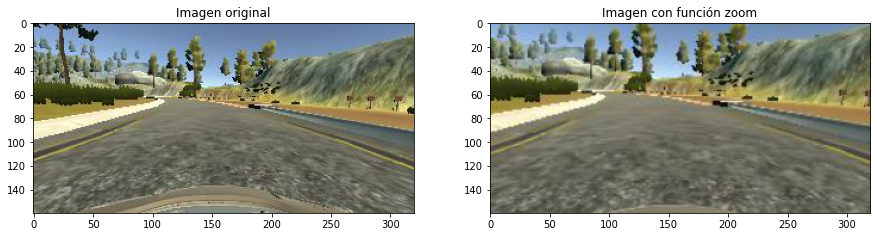

In [24]:
image = image_paths[42]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
#Graficamos el efecto de la función zoom
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(zoomed_image)
plt.title('Imagen con función zoom')
plt.show()

Traslación

In [25]:
def translation(image):
  translation = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = translation .augment_image(image)
  return image

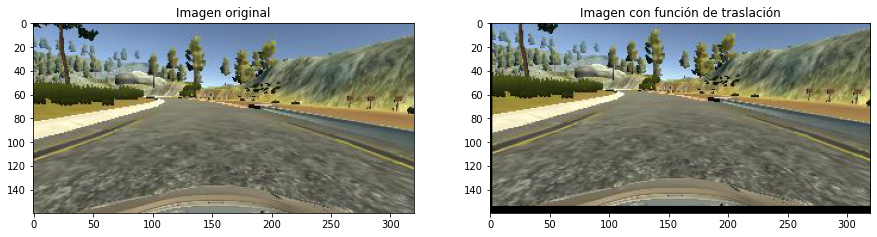

In [26]:
image = image_paths[42]
original_image = mpimg.imread(image)
translated_image = translation(original_image)
#Graficamos el efecto de la función de traslación
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(translated_image)
plt.title('Imagen con función de traslación')
plt.show()

Brillo

In [27]:
def random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

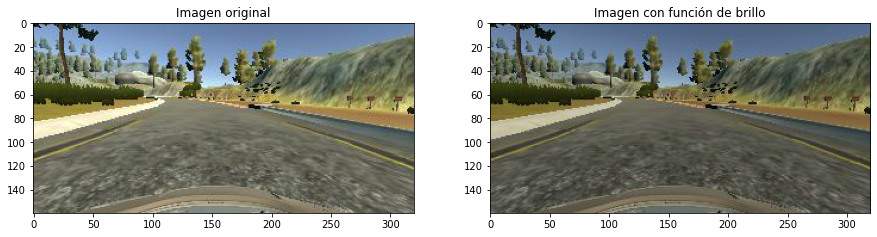

In [28]:
image = image_paths[42]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)
#Graficamos el efecto de la función de traslación
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(brightness_altered_image)
plt.title('Imagen con función de brillo')
plt.show()

Efecto espejo

In [29]:
def random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

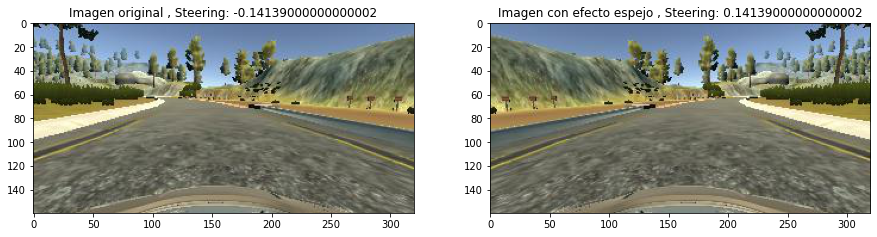

In [30]:
image = image_paths[42]
steering_angle = steerings[42]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)
#Graficamos el efecto de la función de traslación
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original , ' + 'Steering: ' + str(steering_angle))
plt.subplot(1,2,2)
plt.imshow(flipped_image)
plt.title('Imagen con efecto espejo , ' + 'Steering: ' + str(flipped_steering_angle))
plt.show()

Difuminado

In [31]:
def random_blur(image):
  size=random.choice([3, 5, 7])
  image = cv2.GaussianBlur(image,(size,size),0)
  return image

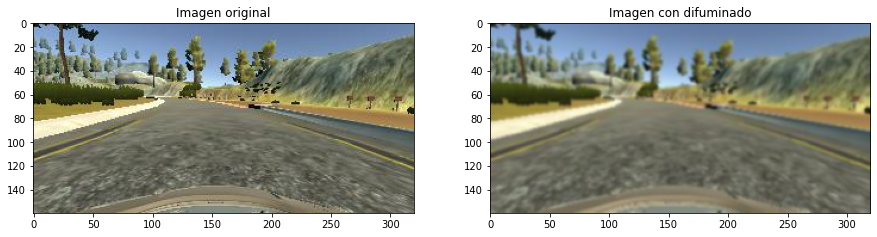

In [32]:
image = image_paths[42]
steering_angle = steerings[42]
original_image = mpimg.imread(image)
randomblur_altered_image = random_blur(original_image)
#Graficamos el efecto de la función de traslación
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(randomblur_altered_image)
plt.title('Imagen con difuminado')
plt.show()

In [33]:
#Función para seleccionar el o los efectos
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = translation(image)
  if np.random.rand() < 0.5:
    image = random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = random_flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = random_blur(image)
  return image, steering_angle

In [34]:
#Ejemplo de la función anterior en algunas imagenes

ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Imagen original")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Imagen modificada")

Output hidden; open in https://colab.research.google.com to view.

Preprocesamiento de las imágenes

In [35]:
#Se define el tamaño final de las imágenes para procesar
img_height, img_width, img_channels = 66, 200, 3

In [36]:
#Función de preprocesamiento de imágenes
def img_preprocess(img):
  #img= mpimg.imread(img)
  img = img[60:140 , : , : ]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  dim = (img_width, img_height)
  img = cv2.resize(img, dim, cv2.INTER_AREA)
  img = img/255
  return img

In [37]:
# La función batch_generator, se encargará de generar una muestra de datos aumentados según la configuración.
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [38]:
#Generamos un ejemplo de la función de preprocesamiento con solo un elemento de training y uno de test.
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(X_test, y_test, 1, 0))

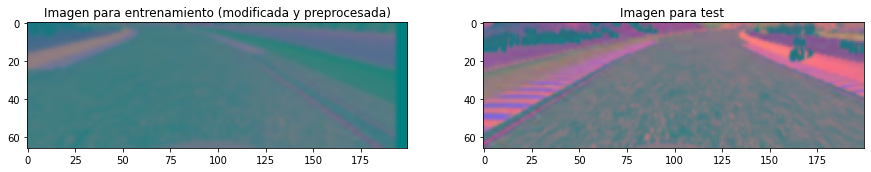

In [39]:
#Mostramos una imagen de entrenamiento y una de test

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(x_train_gen[0])
plt.title('Imagen para entrenamiento (modificada y preprocesada)')
plt.subplot(1,2,2)
plt.imshow(x_test_gen[0])
plt.title('Imagen para test ')
plt.show()

Definición del modelo

In [40]:
# Definición del modelo de Nvidia
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(img_height, img_width, img_channels), activation='elu'))
  model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  optimizer = Adam(lr=0.0001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [41]:
#Se muestran las etapas del modelo
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Obtención del modelo

In [42]:
# Obtención del modelo

import time
start = time.time()
history = model.fit(batch_generator(X_train, y_train, 100, 1), 
                    steps_per_epoch=300, 
                    epochs=30, 
                    validation_data=batch_generator(X_test, y_test, 100, 0),
                    validation_steps=200, 
                    verbose=1)
end = time.time()
print(end - start)

Epoch 1/30
300/300 [==============================] - 1262s 4s/step - loss: 0.0356 - val_loss: 0.0266
Epoch 2/30
300/300 [==============================] - 487s 2s/step - loss: 0.0266 - val_loss: 0.0253
Epoch 3/30
300/300 [==============================] - 483s 2s/step - loss: 0.0267 - val_loss: 0.0240
Epoch 4/30
300/300 [==============================] - 481s 2s/step - loss: 0.0243 - val_loss: 0.0237
Epoch 5/30
300/300 [==============================] - 480s 2s/step - loss: 0.0235 - val_loss: 0.0234
Epoch 6/30
300/300 [==============================] - 478s 2s/step - loss: 0.0224 - val_loss: 0.0244
Epoch 7/30
300/300 [==============================] - 482s 2s/step - loss: 0.0223 - val_loss: 0.0229
Epoch 8/30
300/300 [==============================] - 478s 2s/step - loss: 0.0207 - val_loss: 0.0229
Epoch 9/30
300/300 [==============================] - 478s 2s/step - loss: 0.0207 - val_loss: 0.0240
Epoch 10/30
300/300 [==============================] - 486s 2s/step - loss: 0.0202 - val_l

Text(0.5, 0, 'Epoch')

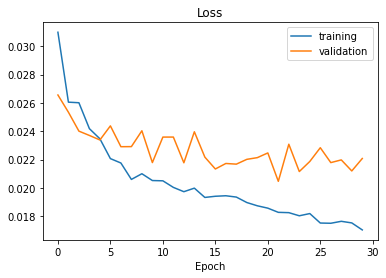

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [44]:
model.save('/content/drive/My Drive/Colab Notebooks/SDC_15/model_aumentado_Erick_Casanova.h5')